In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pydicom as dcm
import math
from tensorflow import keras
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense,  Activation,Dropout,MaxPooling2D,BatchNormalization
from tensorflow.keras.layers import Input,Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D,MaxPooling2D,LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from skimage import morphology
from scipy import ndimage
from tensorflow.keras.models import Model,Sequential,load_model
%matplotlib inline
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence,to_categorical
import math
from tensorflow.keras import losses,optimizers,regularizers
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import r2_score
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input as resnetProcess_input

In [2]:
labels = pd.read_csv("stage_2_train_labels.csv")

In [3]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [4]:
labels.shape

(30227, 6)

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [6]:
labels[labels.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [7]:
labels[~labels.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

In [8]:
labels.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

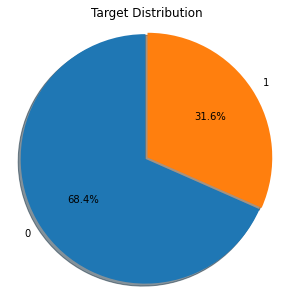

In [9]:
label_count=labels['Target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

In [10]:
print("Are there Unique Patients In Data Set ?? " ,labels['patientId'].is_unique)

Are there Unique Patients In Data Set ??  False


In [11]:
duplicateRowsDF = labels[labels.duplicated(['patientId'])]
duplicateRowsDF.shape

(3543, 6)

In [12]:
labels[labels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [13]:
labels[labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

,patientId,x,y,width,height,Target
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [14]:
class_labels = pd.read_csv('stage_2_detailed_class_info.csv')
class_labels.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [15]:
class_labels.shape

(30227, 2)

In [16]:
class_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [17]:
class_labels['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

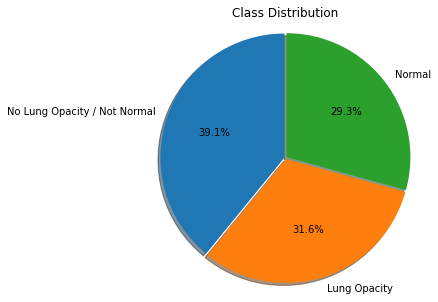

In [18]:
label_count=class_labels['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [19]:
duplicateClassRowsDF = class_labels[class_labels.duplicated(['patientId'])]
duplicateClassRowsDF.shape


(3543, 2)

In [20]:
duplicateClassRowsDF.head(2)

,patientId,class
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [21]:
class_labels[class_labels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

,patientId,class
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [22]:
training_data = pd.concat([labels, class_labels['class']], axis = 1)

training_data.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [23]:
import matplotlib.patches as patches

def inspectImages(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = "E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/stage_2_train_images/"+'{}.dcm'.format(patientImage)
        data_row_img_data = dcm.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target:'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

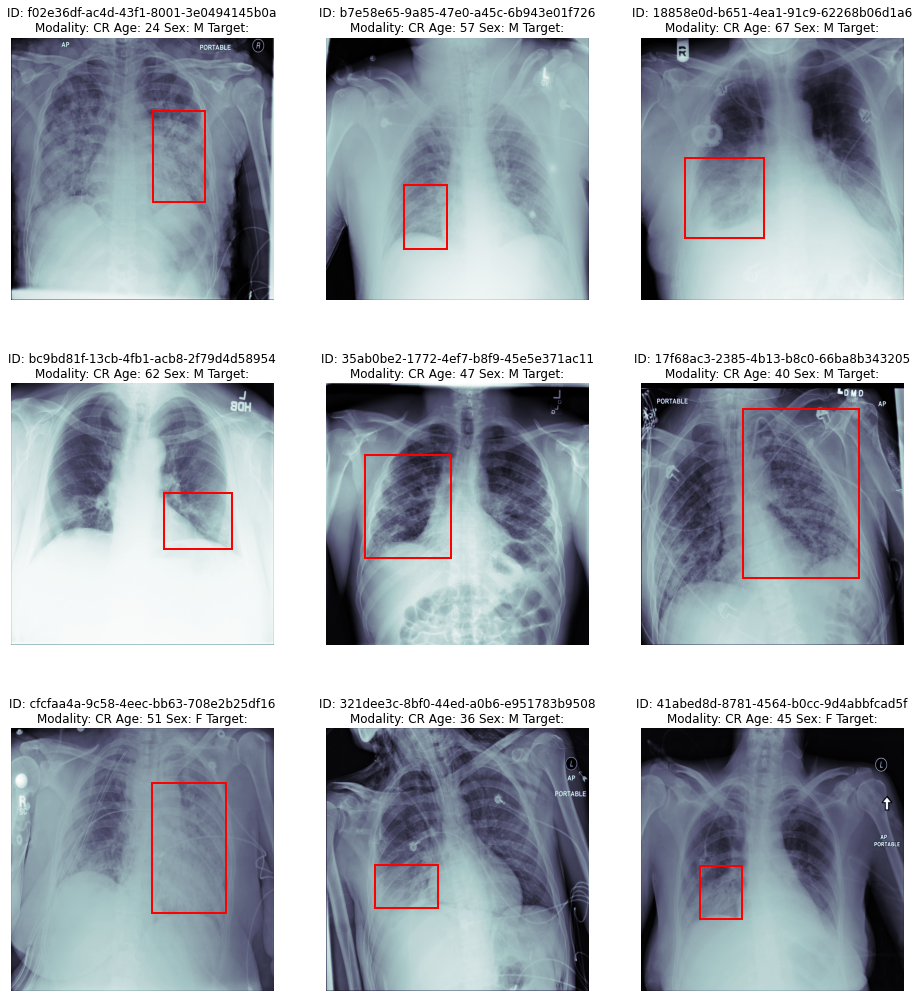

In [24]:
inspectImages(training_data[training_data['Target']==1].sample(9))

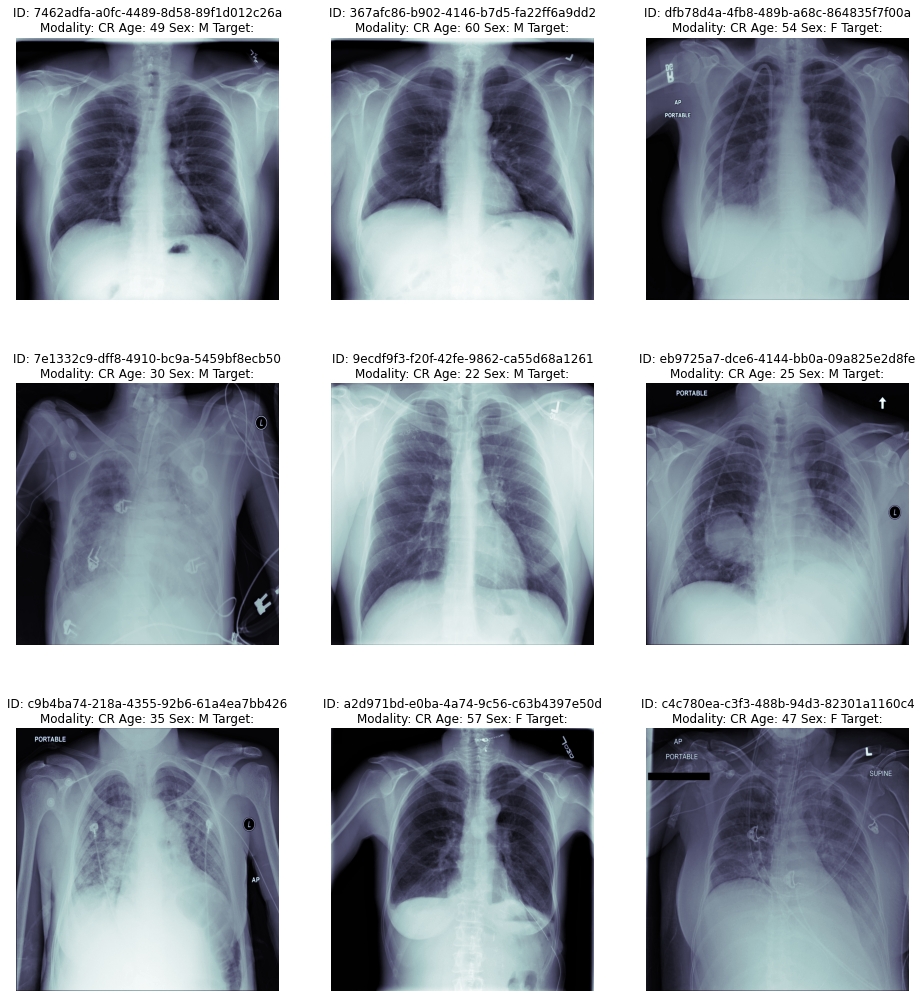

In [25]:
inspectImages(training_data[training_data['Target']==0].sample(9))

# Image Processing

In [30]:
from skimage.io import imread,imshow

In [31]:
img1 = imread("E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg")
img2 = imread("E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/000e3a7d-c0ca-4349-bb26-5af2d8993c3d.jpg")
img3 = imread("E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/00a221ac-da8f-4f61-8d4f-fc195143491d.jpg")
img4 = imread("E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/00ad18b7-06ee-4c4d-abca-14bdf814e8b2.jpg")

# Resizing the image

In [32]:
screen_res = 1280, 720
scale_width = screen_res[0] / img1.shape[1]
scale_height = screen_res[1] /img1.shape[0]
scale = min(scale_width, scale_height)
window_width = int(img1.shape[1] * scale)
window_height = int(img1.shape[0] * scale)

cv2.namedWindow('LUNG IMAGE ', cv2.WINDOW_NORMAL)
cv2.resizeWindow('LUNG IMAGE ', window_width, window_height)
cv2.imshow('LUNG IMAGE ',img1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
img1.shape

(1024, 1024)

# Morphological Operations

In [ ]:
img = cv2.imread('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/0000a175-0e68-4ca4-b1af-167204a7e0bc.jpg')

In [ ]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')
    plt.imshow(img)

In [ ]:
display_img(img)

# Erosion
Erosion removes pixels on object boundaries. The number of pixels added or removed from the objects in an image depends on the size and shape of the structuring element used to process the image.

In [ ]:
kernel = np.ones((5,5),np.uint8)
erosion1 = cv2.erode(img,kernel,iterations = 10)

In [ ]:
display_img(erosion1)

# Dicom Pre-processing

In [ ]:
file_path = "E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/stage_2_test_images/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm"

In [ ]:
medical_image = dcm.read_file(file_path)
print(medical_image)

In [ ]:
print("Rows: ", medical_image.Rows)
print("Columns: ", medical_image.Columns)
print("Body Content: ", medical_image.BodyPartExamined)

In [ ]:
#to represent the values in hexadecimals 0x is added as prefix
print(medical_image[0x0028, 0x0010])
print(medical_image[0x0028, 0x0011])
print(medical_image[0x0018, 0x0015])

In [ ]:
image = medical_image.pixel_array
print(image.shape)

In [ ]:
lung=medical_image.pixel_array #load the image pixel data as a numpy array
plt.figure()
plt.imshow(lung,cmap='gray')

# Converting Images To JPG form

In [ ]:
#if want png else false
PNG = False
#To specify thr .dcm folder path
folder_path = "E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/stage_2_test_images"
jpg_folder_path = "E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm','.jpg')
    else:
        image = image.replce('.dcm','.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n%50 ==0:
        print('{} image converted'.format(n))

In [ ]:
#if want png else false
PNG = False
#To specify thr .dcm folder path
folder_path = "E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/stage_2_train_images"
jpg_folder_path = "E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_train"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm','.jpg')
    else:
        image = image.replce('.dcm','.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n%50 ==0:
        print('{} image converted'.format(n))

# BASIC OPERATIONS WITH MEDICAL IMAGE

# CROPPING

In [ ]:
image = cv2.imread('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/000e3a7d-c0ca-4349-bb26-5af2d8993c3d.jpg')
height, width = image.shape[:2]

start_row, start_col = int(height * .25), int(width * .25)

end_row, end_col = int(height * .80), int(width * .90)

cropped = image[start_row:end_row , start_col:end_col]

cv2.imshow("Original Image", image)
cv2.waitKey(0) 
cv2.imshow("Cropped Image", cropped) 
cv2.waitKey(0) 
cv2.destroyAllWindows()

# SCALING

In [ ]:
# load our input image
image = cv2.imread('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/000e3a7d-c0ca-4349-bb26-5af2d8993c3d.jpg')

#3/4 of it's original size
image_scaled = cv2.resize(image, None, fx=0.75, fy=0.75)
cv2.imshow('Scaling - Linear Interpolation', image_scaled) 
cv2.waitKey()

#double the size of our image
img_scaled = cv2.resize(image, None, fx=2, fy=2, interpolation = cv2.INTER_CUBIC)
cv2.imshow('Scaling - Cubic Interpolation', img_scaled)
cv2.waitKey()

#skew the re-sizing by setting exact dimensions
img_scaled = cv2.resize(image, (900, 400), interpolation = cv2.INTER_AREA)
cv2.imshow('Scaling - Skewed Size', img_scaled) 
cv2.waitKey()

cv2.destroyAllWindows()

# ROTATIONS

In [ ]:
import cv2
import numpy as np

image = cv2.imread('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/00a221ac-da8f-4f61-8d4f-fc195143491d.jpg')
height, width = image.shape[:2]

#Divide by two to rotate the image around its centre
rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), 90, .5)

rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

cv2.imshow('Rotated Image', rotated_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# Let's now see how to horizontaly flip.
flipped = cv2.flip(image, 0)
cv2.imshow('Horizontal Flip', flipped) 
cv2.waitKey()
cv2.destroyAllWindows()

# SHARPENING

In [ ]:
import cv2
import numpy as np

image = cv2.imread('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/00ad18b7-06ee-4c4d-abca-14bdf814e8b2.jpg')
cv2.imshow('Original', image)

# Create our shapening kernel, we don't normalize since the 
# the values in the matrix sum to 1
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,9,-1], 
                              [-1,-1,-1]])

# applying different kernels to the input image
sharpened = cv2.filter2D(image, -1, kernel_sharpening)

cv2.imshow('Image Sharpening', sharpened)

cv2.waitKey(0)
cv2.destroyAllWindows()

# Convolutions and Blurring

In [ ]:
import cv2
import numpy as np

image = cv2.imread('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/00ad18b7-06ee-4c4d-abca-14bdf814e8b2.jpg')
cv2.imshow('Original Image', image)
cv2.waitKey(0)

kernel_3x3 = np.ones((3, 3), np.float32) / 9

blurred = cv2.filter2D(image, -1, kernel_3x3)
cv2.imshow('3x3 Kernel Blurring', blurred)
cv2.waitKey(0)

kernel_7x7 = np.ones((7, 7), np.float32) / 49

blurred2 = cv2.filter2D(image, -1, kernel_7x7)
cv2.imshow('7x7 Kernel Blurring', blurred2)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Reading the Dicom images meta data and appending it to the training set

In [34]:
## DCIM image contain the meta data alon with it, 
## Function to read the dcim data and appending to the resultset
def readDCIMData(rowData):
    dcm_file = 'E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/stage_2_train_images/'+'{}.dcm'.format(rowData.patientId)
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    return dcm_data.PatientSex,dcm_data.PatientAge

In [35]:
## Reading the image data and append it to the training_data dataset
training_data['sex'], training_data['age'] = zip(*training_data.apply(readDCIMData, axis=1))

In [36]:
training_data.info()
## There are 30227  records
## sex and age also have the smae count indicating that there are no images missing every patient has an dicom image 
## Age should be a numeric , currently it is an objetc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   sex        30227 non-null  object 
 8   age        30227 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 2.1+ MB


In [37]:
training_data['age'] = training_data.age.astype(int)
# Converting age to Numeric as the current data type is a String

In [38]:
training_data.describe()
## The mean age is 46 years , where as minimum age is 1 year and the max age is 155 which seems to be an outlier
## 50% of the patiens are of aroudn 49 age , the std deviation is 16 which sugges that age is not normally distubuted

,x,y,width,height,Target,age
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108,46.797764
std,204.574172,148.940488,59.289475,157.750755,0.464963,16.892940
min,2.000000,2.000000,40.000000,45.000000,0.000000,1.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000,34.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000,49.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000,59.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000,155.000000


In [39]:
training_data.sex.value_counts()
## there are only two genders 

M    17216
F    13011
Name: sex, dtype: int64

# MODEL BUILDING

In [40]:
## Just taking a 800 samples from the dataset
sample_trainigdata = training_data.groupby('class', group_keys=False).apply(lambda x: x.sample(800))

In [41]:
## Checking the training data set with class distbution
sample_trainigdata["class"].value_counts()

Lung Opacity                    800
No Lung Opacity / Not Normal    800
Normal                          800
Name: class, dtype: int64

In [42]:
sample_trainigdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 15092 to 7891
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  2400 non-null   object 
 1   x          800 non-null    float64
 2   y          800 non-null    float64
 3   width      800 non-null    float64
 4   height     800 non-null    float64
 5   Target     2400 non-null   int64  
 6   class      2400 non-null   object 
 7   sex        2400 non-null   object 
 8   age        2400 non-null   int32  
dtypes: float64(4), int32(1), int64(1), object(3)
memory usage: 178.1+ KB


In [43]:
## Pre Processing the image
from tensorflow.keras.applications.mobilenet import preprocess_input

images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = 'E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [44]:
## Reading the images into numpy array
images,labels = populateImage(sample_trainigdata)

In [45]:
images.shape , labels.shape
## The image is of 128*128 with 3 channels

((2400, 128, 128, 3), (2400,))

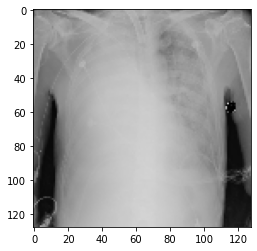

In [46]:
## Checking one of the converted image 
plt.imshow(images[100])

In [47]:
## check the unique labels
np.unique(labels),len(np.unique(labels))

(array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
       dtype='<U28'),
 3)

In [48]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(labels)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [50]:
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

# Customized CNN Model 

In [51]:
## CNN Model without transfer learning , we start with 32 filters with 5,5 kernal and no padding , then 64 and 128 wiht drop layers in between 
## And softmax activaation as the last layer
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [52]:
cnn = cnn_model(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE,3,3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

C:\Users\Udhayan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 30, 
                  validation_data = (X_val,y_val),
                  batch_size = 30)

In [ ]:
fcl_loss, fcl_accuracy = cnn.evaluate(X_test, y_test, verbose=2)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

In [53]:
X_train1 = X_train.copy()
X_val1 = X_val.copy()
X_test1 = X_test.copy()

# CNN with ResNet50

In [57]:
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

resnet_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train[0].shape)
print(X_train[0].shape)
#model = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))

train_ds = preprocess_input(X_train1) 
train_val_df = preprocess_input(X_val1)


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(32, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')

cnn_resnet_model = models.Sequential([
    resnet_base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

(128, 128, 3)


In [55]:
from tensorflow.keras.callbacks import EarlyStopping

cnn_resnet_model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
history =cnn_resnet_model.fit(train_ds, y_train, epochs=5, validation_data=(train_val_df,y_val))

Epoch 1/5


C:\Users\Udhayan\anaconda3\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


53/53 [==============================] - 182s 3s/step - loss: 0.6709 - accuracy: 0.5679 - val_loss: 26.8513 - val_accuracy: 0.3556
Epoch 2/5
53/53 [==============================] - 172s 3s/step - loss: 0.4810 - accuracy: 0.6673 - val_loss: 6.4458 - val_accuracy: 0.3861
Epoch 3/5
53/53 [==============================] - 176s 3s/step - loss: 0.4318 - accuracy: 0.6946 - val_loss: 2.2356 - val_accuracy: 0.4278
Epoch 4/5
53/53 [==============================] - 175s 3s/step - loss: 0.3910 - accuracy: 0.7375 - val_loss: 1.9535 - val_accuracy: 0.5139
Epoch 5/5
53/53 [==============================] - 180s 3s/step - loss: 0.3435 - accuracy: 0.7708 - val_loss: 1.4538 - val_accuracy: 0.5333


1/1 [==============================] - 0s 64ms/step
[[0.9211527  0.06885122 0.0099961 ]]
Prediction Of Our Model :  Pneumonia


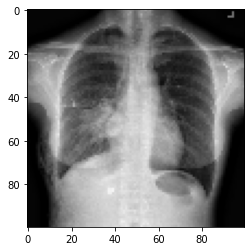

In [59]:
import numpy as np
# from google.colab.patches import cv2_imshow
import cv2
from tensorflow.keras.preprocessing import image
xtest_image = image.load_img('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/00ad18b7-06ee-4c4d-abca-14bdf814e8b2.jpg', target_size = (128, 128))
#'/content/drive/MyDrive/Tensorflow_and_other_tools/Dataset/Chest/NewFolder/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
xtest_image = image.img_to_array(xtest_image)
xtest_image = np.expand_dims(xtest_image, axis = 0)
results = cnn_resnet_model.predict(xtest_image)
# training_set.class_indices
imggg = cv2.imread('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/jpeg_test/00ad18b7-06ee-4c4d-abca-14bdf814e8b2.jpg')
imggg = np.array(imggg)
imggg = cv2.resize(imggg,(100,100))
plt.imshow(imggg)
# cv2_imshow(imggg)
print(results)
if results[0][0].round() == 0:
    prediction = 'Normal'
else:
    prediction = 'Pneumonia'
print("Prediction Of Our Model : ",prediction)

1/1 [==============================] - 0s 64ms/step
[[0.33005986 0.6349603  0.03497985]]
Prediction Of Our Model :  Normal


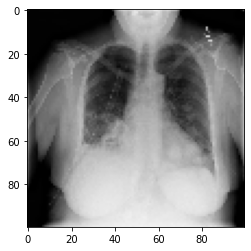

In [60]:
import numpy as np
# from google.colab.patches import cv2_imshow
import cv2
from tensorflow.keras.preprocessing import image
xtest_image = image.load_img('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/Jpeg_train/0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg', target_size = (128, 128))
#'/content/drive/MyDrive/Tensorflow_and_other_tools/Dataset/Chest/NewFolder/chest_xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
xtest_image = image.img_to_array(xtest_image)
xtest_image = np.expand_dims(xtest_image, axis = 0)
results = cnn_resnet_model.predict(xtest_image)
# training_set.class_indices
imggg = cv2.imread('E:/YEAR 3/Quater 1/Medical Imaging/Project/Dataset/New folder/Jpeg_train/0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg')
imggg = np.array(imggg)
imggg = cv2.resize(imggg,(100,100))
plt.imshow(imggg)
# cv2_imshow(imggg)
print(results)
if results[0][0].round() == 0:
    prediction = 'Normal'
else:
    prediction = 'Pneumonia'
print("Prediction Of Our Model : ",prediction)